In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import gym
import time
from tqdm import tqdm
import json
from livelossplot import PlotLosses
import torch.nn.functional as F
import torch.nn as nn
from livelossplot import PlotLosses

In [4]:
# test
f1 = '/media/ghost-083/SolarSystem1/1_Research/00_Transfer-RL/Task_similarity/dataset/Pendulum_dataset_1.json'
data1 = json.load(open(f1))

f2 = '/media/ghost-083/SolarSystem1/1_Research/00_Transfer-RL/Task_similarity/dataset/Pendulum_dataset_2.json'
data2 = json.load(open(f2))


In [8]:
data1['env arguments']

[7.0, 0.1, 0.001]

In [9]:
data2['env arguments']

[7.0, 0.1, 0.001]

In [2]:
f_source = 'data/Pendulum_dataset_0.json'
json_data_source = json.load(open(f_source))

f_target1 = 'data/Pendulum_dataset_1.json'
json_data_target1 = json.load(open(f_target1))

f_target2 = 'data/Pendulum_dataset_2.json'
json_data_target2 = json.load(open(f_target2))

f_target3 = 'data/Pendulum_dataset_3.json'
json_data_target3 = json.load(open(f_target3))

print('data loaded successfully!')

In [3]:

# helper functions


def get_dataset(json_data):
  source_data = json_data['data']
  source_state_action_data = []
  for trj in source_data:
      for d in trj:
          x = []
          s, a, s_next, r, terminated = d
          # m = s + a + s_next 
          m = s + a + [r]
          source_state_action_data.append(m)

  dataset = np.array(source_state_action_data)
  data = torch.tensor(dataset)
  return data


class PendulumDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample, label = self.dataset[idx, :-1], self.dataset[idx, -1]
        return sample, label

      
  
# model 
class DynamicsModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear_1 = nn.Linear(num_features, 32)
        self.linear_2 = nn.Linear(32, 16)
        self.linear_3 = nn.Linear(16, 32)
        self.linear_4 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.linear_1(x)
        z = self.linear_2(x)
        x = self.linear_3(z)
        x = self.linear_4(x)
        return x, z


class DynamicsModelSuccessor(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear_1 = nn.Linear(num_features, 32)
        self.linear_2 = nn.Linear(32, 32)
        self.linear_3 = nn.Linear(32, 16)
        self.linear_4 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.linear_2(x)
        phi = self.linear_3(x)
        x = self.linear_4(phi)
        return x, phi


def train_model(train_loader, lr, model_name=None):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # random_seed = 9029323
  learning_rate = lr
  num_epochs = 25

  # torch.manual_seed(random_seed)
  model = DynamicsModelSuccessor(num_features=4)
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_func = nn.MSELoss()

  liveloss = PlotLosses()

  for epoch in range(num_epochs): 
      model.train() 
      for batch, label in train_loader:
          logs = {}
          batch, label = batch.to(device).float(), label.to(device).float()
          s_next_pred, latent = model(batch)
          loss = 5 * loss_func(s_next_pred, label)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # liveloss plotting
      logs['loss'] = loss.item()
      liveloss.update(logs)
      liveloss.send()

  torch.save(model.state_dict(), 'saved_data/{}.pth'.format(model_name))



In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

small_dataset = np.array(state_action_data)
data = torch.tensor(small_dataset)


class PendulumDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample, label = self.dataset[idx, :-1], self.dataset[idx, -1]
        return sample, label

pendulum_dataset = PendulumDataset(data)
batch_size = 32
train_loader = DataLoader(dataset=pendulum_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

for sample, label in train_loader:
    print(f'input shape: {sample.size()}, label shape: {label.size()}')
    break

input shape: torch.Size([32, 4]), label shape: torch.Size([32])


In [5]:
import torch.nn.functional as F
import torch.nn as nn

# model 
class RewardModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear_1 = nn.Linear(num_features, 32)
        self.linear_2 = nn.Linear(32, 16)
        self.linear_3 = nn.Linear(16, 32)
        self.linear_4 = nn.Linear(32, 1)


    def forward(self, x):
        x = self.linear_1(x)
        z = self.linear_2(x)
        x = self.linear_3(z)
        r = self.linear_4(x)
        return r

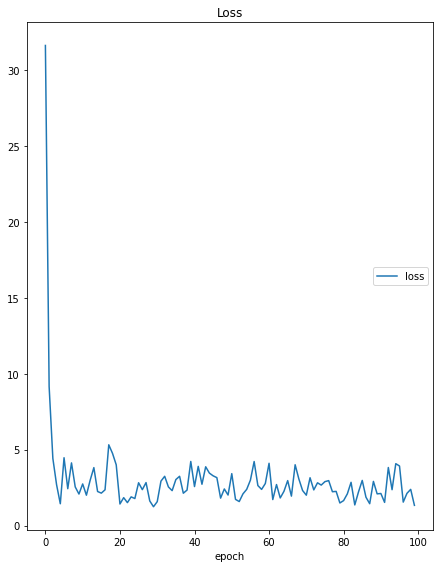

Loss
	loss             	 (min:    1.247, max:   31.595, cur:    1.338)


In [11]:
from livelossplot import PlotLosses


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 356594
learning_rate = 0.00001
num_epochs = 100

torch.manual_seed(random_seed)
model = RewardModel(num_features=4)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

liveloss = PlotLosses()

for epoch in range(num_epochs): 
    model.train() 
    for batch, label in train_loader:
        logs = {}
        batch, label = batch.to(device).float(), label.to(device).float()
        r_hat = model(batch)
        r_hat = torch.flatten(r_hat)
        loss = loss_func(r_hat, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # liveloss plotting
    logs['loss'] = loss.item()
    liveloss.update(logs)
    liveloss.send()

torch.save(model.state_dict(), 'saved_data/model_pendulum_reward.pth')b

In [ ]:

# get dataset 
source_data = get_dataset(json_data_source)
target_data1 = get_dataset(json_data_target1)
target_data2 = get_dataset(json_data_target2)
target_data3 = get_dataset(json_data_target3)

pendulum_dataset_source = PendulumDataset(source_data)
pendulum_dataset_target1 = PendulumDataset(target_data1)
pendulum_dataset_target2 = PendulumDataset(target_data2)
pendulum_dataset_target3 = PendulumDataset(target_data3)


batch_size = 16
source_loader = DataLoader(dataset=pendulum_dataset_source, 
                          batch_size=batch_size, 
                          shuffle=True)

target_loader1 = DataLoader(dataset=pendulum_dataset_target1, 
                          batch_size=batch_size, 
                          shuffle=True)
target_loader2 = DataLoader(dataset=pendulum_dataset_target2, 
                          batch_size=batch_size, 
                          shuffle=True)
target_loader3 = DataLoader(dataset=pendulum_dataset_target3, 
                          batch_size=batch_size, 
                          shuffle=True)


for sample, label in source_loader:
    print(f'input shape: {sample.size()}, label shape: {label.size()}')
    break


In [2]:
# test
batch, label = next(iter(source_loader))
# load source model
model_source = DynamicsModelSuccessor(num_features=4)
model_source.load_state_dict(torch.load('saved_data/model_pendulum_dynamics_0.pth'))
model_source.eval()

pred, phi = model_source(batch.float())
print(pred[:5])
print(label[:5])

0.0001

In [ ]:
# train target
train_model(target_loader1, 'model_pendulum_dynamics_1')


In [ ]:
# train target
train_model(target_loader2, 'model_pendulum_dynamics_2')

In [ ]:
# train target
train_model(target_loader3, 'model_pendulum_dynamics_3')


In [ ]:
# load source model
model_source = DynamicsModel(num_features=4)
model_source.load_state_dict(torch.load('saved_data/model_pendulum_dynamics_0.pth'))
model_source.eval()

# load target model
model_target1 = DynamicsModel(num_features=4)
model_target1.load_state_dict(torch.load('saved_data/model_pendulum_dynamics_1.pth'))
model_target1.eval()

model_target2 = DynamicsModel(num_features=4)
model_target2.load_state_dict(torch.load('saved_data/model_pendulum_dynamics_2.pth'))
model_target2.eval()

model_target3 = DynamicsModel(num_features=4)
model_target3.load_state_dict(torch.load('saved_data/model_pendulum_dynamics_3.pth'))
model_target3.eval()

print('models loaded successfully!')


In [ ]:
def get_similarity(model_source, model_target, target_loader):
  k = 0

  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  mse = nn.MSELoss(reduction='none')

  sim = []

  for batch, label in target_loader:
      pred_t, z_t = model_target(batch.float())
      pred_s, z_s = model_source(batch.float())
      sim_val = cos(z_s, z_t)
      # sim_val = mse(z_t, z_s)
      # sim.append(sim_val.sum(dim=1))
      sim.append(sim_val)

  sim = torch.cat(sim)
  mean_sim = sim.mean().item()
  return mean_sim



sim0 = get_similarity(model_source, model_source, source_loader)
sim1 = get_similarity(model_source, model_target1, target_loader1)
sim2 = get_similarity(model_source, model_target2, target_loader2)
sim3 = get_similarity(model_source, model_target3, target_loader3)


In [ ]:
import matplotlib.pyplot as plt

sim_all = [sim0, sim1, sim2, sim3]
x = [i for i in range(len(sim_all))]

plt.figure(figsize=(10, 8))
plt.scatter(x, sim_all, s=100, c='black')
plt.rcParams['axes.linewidth'] = 2.0
plt.xlabel('tasks', fontsize=18)
plt.ylabel('similarity', fontsize=18)
plt.xticks([0, 1, 2, 3], ['$sim(T_0, T_0)$', '$sim(T_0, T_1)$', '$sim(T_0, T_2)$', '$sim(T_0, T_3)$'], fontsize=18)
plt.show()